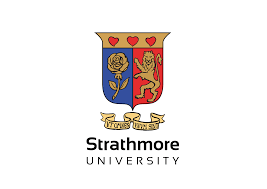

# Project Title

Optimizing agroforestry for climate resilience: A data-driven approach to mitigating environmental shocks and enhancing ecosystem stability

# Objective of the Study
The Objective is to develop machine learning models for optimizing agroforestry systems through species identification, classification, and Carbon sequestration valuation to enhance climate change mitigation and adaptation.

i.	Assess and quantify the potential for carbon sequestration within agroforestry systems using advanced ML techniques, supporting efforts to mitigate climate change.

ii.	To develop machine learning models for species identification and classification within agroforestry systems, enhancing biodiversity management.

iii. To develop a smart decision support system that combines ecological, climate, and species data, providing actionable recommendations in real time to farmers based on climate predictions, soil data, and agroforestry performance metrics.


# Introduction

We will first assess and quantify the potential for carbon sequestration within agroforestry systems using advanced ML techniques, supporting efforts to mitigate climate change. This will be done by calculating the Above Ground Biomass (AGB) using the data collected from the field and existing knowledge on how to calculate the AGB.

We are going to use traditional methods of calculating AGB famously know as Allometric equations and compare them with using various Machine Learning Algorithims. In short we will be comparing the allometric models to machine learning algorithms for aboveground biomass estimation in Agroforestry systems in Kenya

# Relevant Python Libraries

In [ ]:
# Required packages
import pandas as pd  # Load and preprocess data.
import os  # Manage file paths and directories.
import requests  # Send HTTP requests to interact with web APIs or download content from the internet.
import io  # Provides tools for working with I/O streams.
import matplotlib.pyplot as plt  # Create static visualizations like line plots, bar charts, and scatter plots.
import seaborn as sns  # Create enhanced statistical data visualizations like heatmaps and pair plots.
import plotly.express as px  # Quickly create interactive visualizations like scatter plots, line charts, and maps.
import plotly.graph_objects as go  # Build detailed and customized interactive visualizations.
import numpy as np  # Perform numerical operations on arrays and matrices efficiently.
import math  # Perform basic mathematical calculations like logarithms and trigonometric functions.
import ee  # Use Google Earth Engine for large-scale geospatial analysis and satellite data processing.
import scipy.stats as stats  # Perform statistical functions and hypothesis testing.
import folium
import geopandas as gpd
from shapely.geometry import Point
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, cohen_kappa_score, f1_score, precision_score, recall_score, matthews_corrcoef)
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Importing data from my Github



In [ ]:
url = 'https://raw.githubusercontent.com/irungus/Dessertation/main/final_data.csv'
df = pd.read_csv(url, on_bad_lines='skip')

# Visualizing the spatial distribution of the tree species within Kenya

In [ ]:
# Convert DataFrame to GeoDataFrame
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # WGS 84 CRS

# Create a Folium map centered around the first point
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)

# Add points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=1
    ).add_to(m)

    # Add buffer as a circular region
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=row['accuracy'],  # Accuracy column as buffer (meters)
        color="red",
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

# Display the map
m


I want to see how the three species are

--2025-04-10 21:26:16--  https://raw.githubusercontent.com/irungus/Dessertation/main/Counties.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1919228 (1.8M) [application/zip]
Saving to: ‘Counties.zip’

Counties.zip        100%[===================>]   1.83M  --.-KB/s    in 0.1s    

2025-04-10 21:26:16 (17.5 MB/s) - ‘Counties.zip’ saved [1919228/1919228]

Archive:  Counties.zip
  inflating: Counties/County.dbf     
  inflating: Counties/County.prj     
  inflating: Counties/County.sbn     
  inflating: Counties/County.sbx     
  inflating: Counties/County.shp     
  inflating: Counties/County.shp.xml  
  inflating: Counties/County.shx     


<ipython-input-8-2e84bce63918>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {genus: plt.cm.get_cmap('tab10', len(unique_genera))(i) for i, genus in enumerate(unique_genera)}


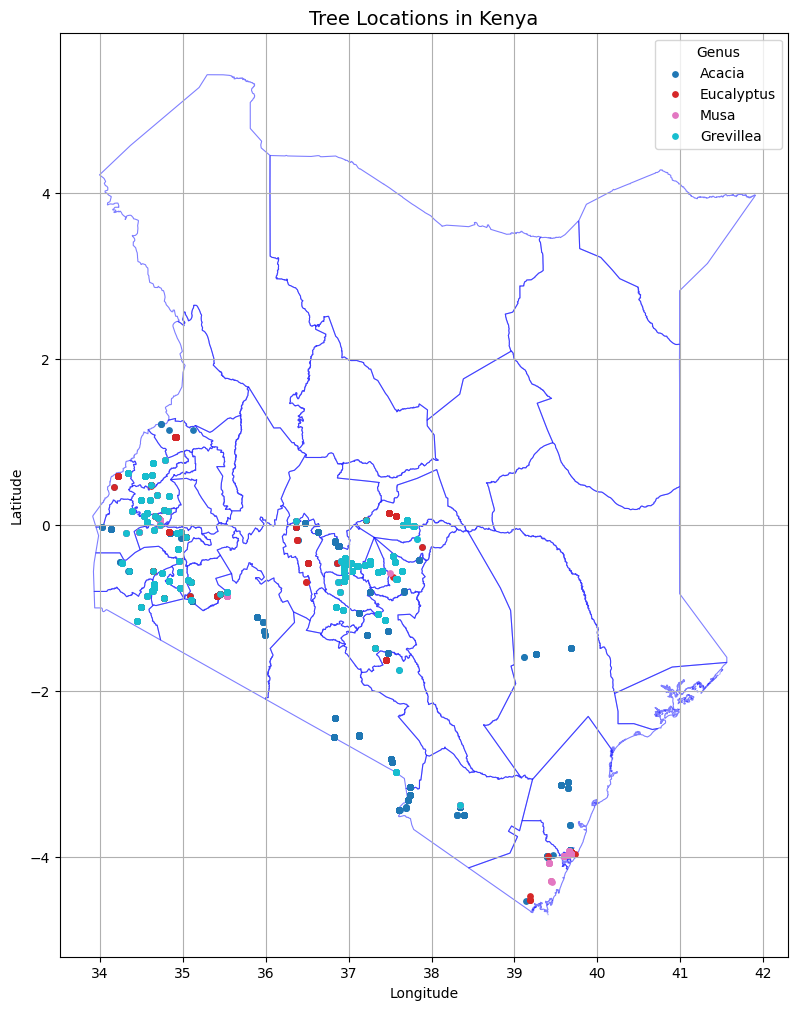

In [ ]:
# Using Kenya counties shapefile from GitHub
zip_url = "https://raw.githubusercontent.com/irungus/Dessertation/main/Counties.zip"
!wget {zip_url} -O Counties.zip
!unzip -o Counties.zip -d Counties

# Load the shapefile
shp_path = "Counties/County.shp"
kenya_counties = gpd.read_file(shp_path)

#Prepare the tree GeoDataFrame from df
# Convert DataFrame to GeoDataFrame
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Convert accuracy column to buffer circles
gdf['buffer'] = gdf.apply(lambda row: row.geometry.buffer(row['accuracy'] / 111320), axis=1)

# Assign a color for each tree genus
unique_genera = gdf['genus'].unique()
color_map = {genus: plt.cm.get_cmap('tab10', len(unique_genera))(i) for i, genus in enumerate(unique_genera)}

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Kenya counties
kenya_counties.plot(ax=ax, color="none", edgecolor="blue", linewidth=0.8, alpha=0.5)

# Plot buffers and points by genus
for genus in unique_genera:
    genus_gdf = gdf[gdf['genus'] == genus]
    genus_gdf.set_geometry('buffer').plot(ax=ax, color=color_map[genus], alpha=0.3, edgecolor='black')
    genus_gdf.set_geometry('geometry').plot(ax=ax, markersize=15, color=color_map[genus], label=genus, marker="o")

# Map settings
plt.title("Tree Locations in Kenya", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Genus", fontsize=10)
plt.grid(True)

plt.show()

# Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FID                     3071 non-null   int64  
 1   agf                     3071 non-null   object 
 2   plotID                  3071 non-null   int64  
 3   transect                3071 non-null   int64  
 4   County                  3071 non-null   object 
 5   genus                   3071 non-null   object 
 6   species                 3071 non-null   object 
 7   dbh                     3071 non-null   int64  
 8   height                  3071 non-null   int64  
 9   canopyd                 3071 non-null   int64  
 10  latitude                3071 non-null   float64
 11  longitude               3071 non-null   float64
 12  altitude                3071 non-null   float64
 13  accuracy                3071 non-null   float64
 14  B11                     3071 non-null   

In [ ]:
df.columns

Index(['FID', 'agf', 'plotID', 'transect', 'County', 'genus', 'species', 'dbh',
       'height', 'canopyd', 'latitude', 'longitude', 'altitude', 'accuracy',
       'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9',
       'NDVI', 'EVI', 'NDWI', 'RDVI', 'NDVI_red_edge', 'mNDVI_red_edge',
       'MSR_red_edge', 'CI_red_edge', 'MSI', 'LSWI', 'MTCI', 'IRECI', 'PSRI',
       'NDVIA', 'TCARI', 'MCARI', 'TVI', 'SAVI', 'Temp_mean', 'Temp_max',
       'Temp_min', 'Temp_skew', 'Temp_kurtosis', 'Elevation_x', 'Precip_mean',
       'Precip_max', 'Precip_min', 'Precip_skew', 'Precip_kurtosis',
       'Elevation_y', 'Slope', 'Aspect', 'Hill_shade', 'VV', 'VH',
       'Backscatter_Difference', 'Backscatter_Division',
       'Backscatter_Amplitude', 'NIR_Contrast', 'NIR_Dissimilarity',
       'NIR_Entropy', 'NIR_Correlation', 'NIR_ASM', 'NIR_Inertia', 'NIR_Shade',
       'NIR_Prominence', 'geometry'],
      dtype='object')

In [ ]:
df.describe()

FID       plotID     transect          dbh       height  \
count  3071.000000  3071.000000  3071.000000  3071.000000  3071.000000   
mean   3267.883751   108.663627     2.512211    45.117226   828.673722   
std    2094.865038    49.159574     1.288801    43.117413   639.897316   
min       0.000000     0.000000     1.000000     5.000000    80.000000   
25%    1569.500000    71.000000     1.000000    20.000000   400.000000   
50%    3111.000000   115.000000     2.000000    35.000000   680.000000   
75%    4699.500000   152.000000     4.000000    55.000000  1100.000000   
max    7102.000000   184.000000     4.000000   390.000000  5000.000000   

           canopyd     latitude    longitude    altitude     accuracy  ...  \
count  3071.000000  3071.000000  3071.000000  3071.00000  3071.000000  ...   
mean    326.596874    -0.870953    36.415453  1481.06899     4.461470  ...   
std     257.419787     1.179407     1.486559   488.40737     0.845487  ...   
min      17.000000    -4.537429    34.022104   -67.60000     0.720000  ...   
25%     130.000000    -1.058631    34.832796  1269.40000     4.460000  ...   
50%     300.000000    -0.563253    36.939160  1524.80000     4.780000  ...   
75%     420.000000    -0.080068    37.467955  1814.00000     4.916000  ...   
max    2700.000000     1.215551    39.731914  2482.40000     5.850000  ...   

       Backscatter_Division  Backscatter_Amplitude  NIR_Contrast  \
count           3071.000000            3071.000000  3.071000e+03   
mean               0.593087              17.971514  1.068292e+13   
std                0.103161               2.857446  1.140418e+13   
min               -0.715679               5.705628  1.736119e+10   
25%                0.536759              16.097128  3.047215e+12   
50%                0.603091              17.805712  7.409560e+12   
75%                0.661006              19.645659  1.394055e+13   
max                0.883159              29.828891  1.168740e+14   

       NIR_Dissimilarity  NIR_Entropy  NIR_Correlation      NIR_ASM  \
count       3.071000e+03  3071.000000      3071.000000  3071.000000   
mean        2.353839e+06     2.275147         0.013729     0.105108   
std         1.262533e+06     0.026184         0.160402     0.003373   
min         1.097723e+05     2.007043        -0.483968     0.104167   
25%         1.408694e+06     2.282174        -0.096723     0.104167   
50%         2.210747e+06     2.282174         0.017478     0.104167   
75%         3.086891e+06     2.282174         0.131135     0.104167   
max         9.112655e+06     2.282174         0.413523     0.142156   

        NIR_Inertia     NIR_Shade  NIR_Prominence  
count  3.071000e+03  3.071000e+03    3.071000e+03  
mean   1.068292e+13 -2.717439e+17    8.119967e+26  
std    1.140418e+13  4.241116e+19    2.129279e+27  
min    1.736119e+10 -8.280000e+20    8.920000e+20  
25%    3.047215e+12 -4.315000e+18    2.475000e+25  
50%    7.409560e+12  6.840470e+15    1.500000e+26  
75%    1.394055e+13  4.645000e+18    6.335000e+26  
max    1.168740e+14  4.490000e+20    4.340000e+28  

[8 rows x 67 columns]

In [ ]:
# List of columns to drop
columns_to_drop = ['FID', 'agf', 'plotID', 'transect', 'County', 'species', 'geometry']

# Drop them from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)

In [ ]:
df_cleaned.head()

genus  dbh  height  canopyd  latitude  longitude  altitude  accuracy  \
0      Acacia   26     600      450 -4.537429  39.139728    50.772     0.915   
1  Eucalyptus   65    1160      680 -4.522492  39.183680    -1.432     0.793   
2  Eucalyptus   35     890      390 -4.522487  39.183677    -2.642     0.988   
3  Eucalyptus   24     810      390 -4.522480  39.183657    -1.658     0.882   
4  Eucalyptus   65    1000      430 -4.472281  39.189929    97.522     1.629   

      B11     B12  ...  Backscatter_Division  Backscatter_Amplitude  \
0  2512.0  1599.0  ...              0.828856              20.402497   
1  2724.0  1758.0  ...              0.657368              18.062384   
2  2724.0  1758.0  ...              0.657368              18.062384   
3  2724.0  1758.0  ...              0.644163              18.530470   
4  2559.5  1728.5  ...              0.684264              18.440184   

   NIR_Contrast  NIR_Dissimilarity  NIR_Entropy  NIR_Correlation   NIR_ASM  \
0  1.988440e+13        3868333.333     2.282174         0.126811  0.104167   
1  3.262890e+12        1482083.333     2.282174         0.008636  0.104167   
2  3.262890e+12        1482083.333     2.282174         0.008636  0.104167   
3  3.181330e+12        1455297.619     2.282174        -0.068179  0.104167   
4  4.900680e+12        1898750.000     2.282174        -0.270936  0.104167   

    NIR_Inertia     NIR_Shade  NIR_Prominence  
0  1.988440e+13  6.900000e+19    1.280000e+27  
1  3.262890e+12 -1.190000e+18    2.150000e+25  
2  3.262890e+12 -1.190000e+18    2.150000e+25  
3  3.181330e+12 -8.180000e+17    1.630000e+25  
4  4.900680e+12 -1.100000e+18    2.030000e+25  

[5 rows x 65 columns]

In [ ]:
df_cleaned['genus'].value_counts()

genus
Acacia        999
Grevillea     876
Eucalyptus    686
Musa          510
Name: count, dtype: int64

In [ ]:
df_cleaned.isna().sum()

genus              0
dbh                0
height             0
canopyd            0
latitude           0
                  ..
NIR_Correlation    0
NIR_ASM            0
NIR_Inertia        0
NIR_Shade          0
NIR_Prominence     0
Length: 65, dtype: int64

<Axes: >

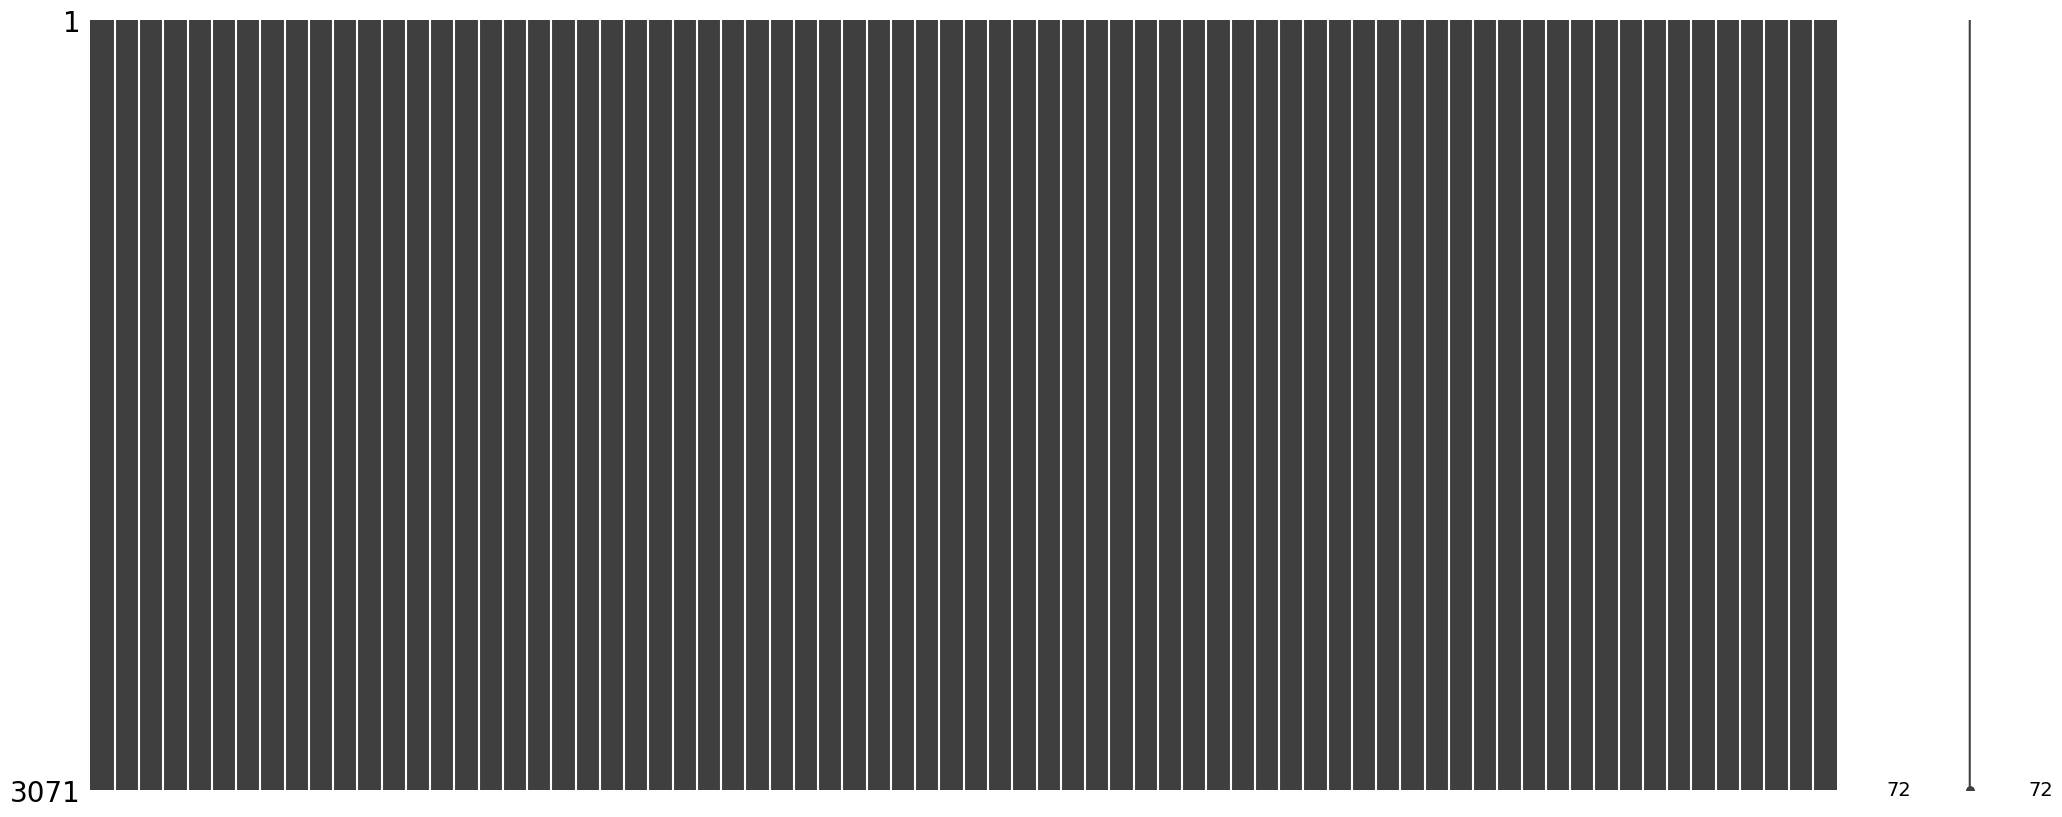

In [ ]:
import missingno as msno
msno.matrix(df)

# Box plots
To check if there are outliers

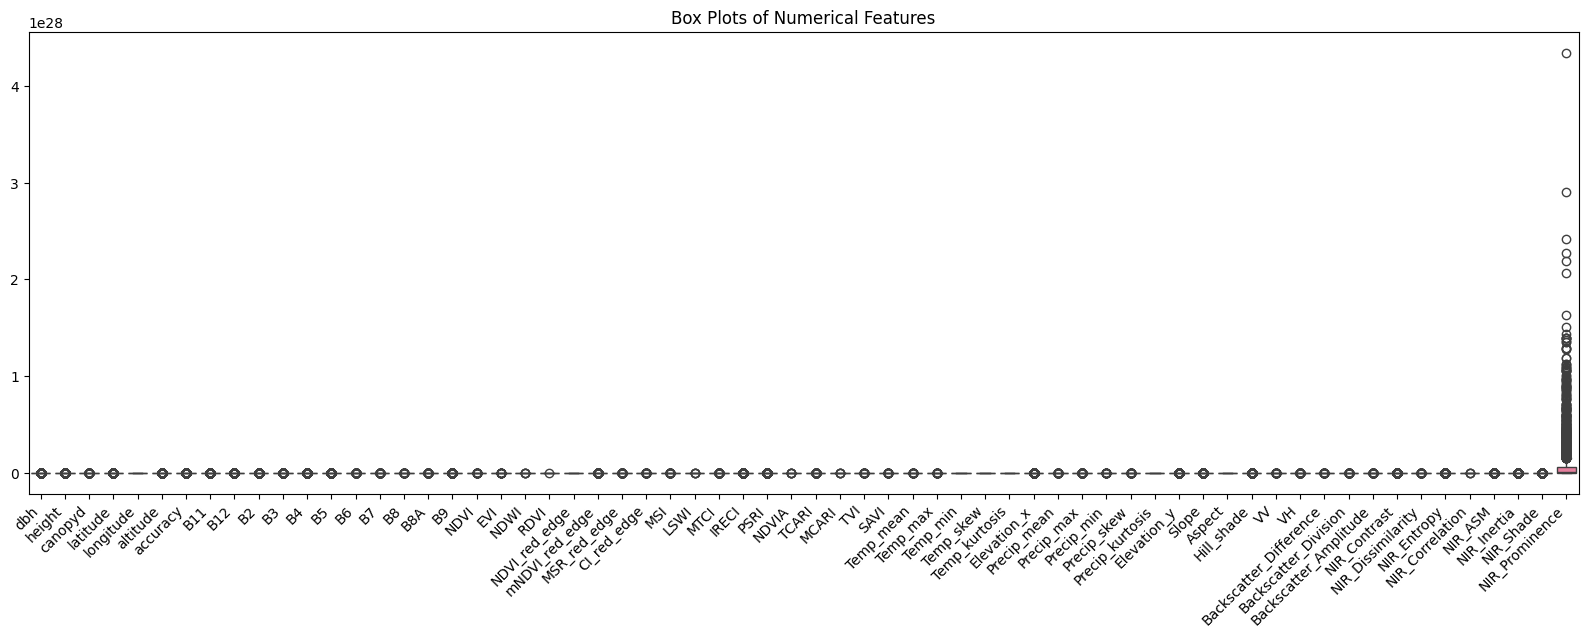

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=df_cleaned)
plt.xticks(rotation=45, ha='right')
plt.title('Box Plots of Numerical Features')
plt.show()


In [ ]:
numeric_df = df_cleaned.select_dtypes(include=np.number)
correlations = numeric_df.corr()
correlations.to_csv('correlations.csv')

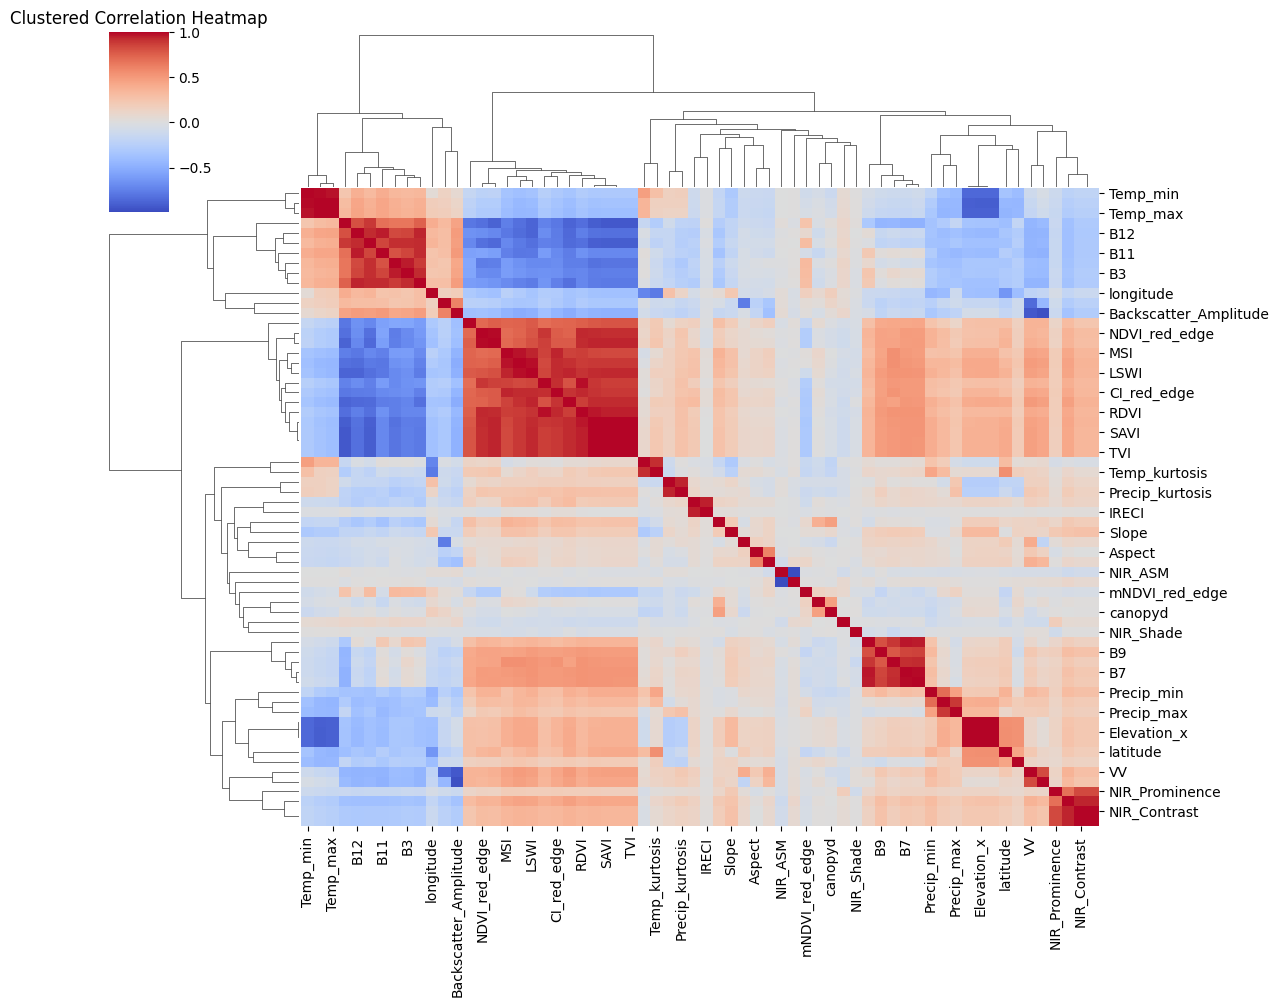

In [ ]:

# Select only numeric columns for correlation
numeric_cols = df_cleaned.select_dtypes(include=np.number).columns
df_numeric = df_cleaned[numeric_cols]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(12, 10), annot=False)
plt.title('Clustered Correlation Heatmap')
plt.show()


In [ ]:
df_cleaned.columns

Index(['genus', 'dbh', 'height', 'canopyd', 'latitude', 'longitude',
       'altitude', 'accuracy', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B9', 'NDVI', 'EVI', 'NDWI', 'RDVI', 'NDVI_red_edge',
       'mNDVI_red_edge', 'MSR_red_edge', 'CI_red_edge', 'MSI', 'LSWI', 'MTCI',
       'IRECI', 'PSRI', 'NDVIA', 'TCARI', 'MCARI', 'TVI', 'SAVI', 'Temp_mean',
       'Temp_max', 'Temp_min', 'Temp_skew', 'Temp_kurtosis', 'Elevation_x',
       'Precip_mean', 'Precip_max', 'Precip_min', 'Precip_skew',
       'Precip_kurtosis', 'Elevation_y', 'Slope', 'Aspect', 'Hill_shade', 'VV',
       'VH', 'Backscatter_Difference', 'Backscatter_Division',
       'Backscatter_Amplitude', 'NIR_Contrast', 'NIR_Dissimilarity',
       'NIR_Entropy', 'NIR_Correlation', 'NIR_ASM', 'NIR_Inertia', 'NIR_Shade',
       'NIR_Prominence'],
      dtype='object')

In [ ]:
columns_to_drop = ['NDWI', 'RDVI', 'NDVI_red_edge','mNDVI_red_edge', 'MSR_red_edge', 'CI_red_edge', 'MSI', 'LSWI', 'MTCI','Temp_max', 'Temp_min','Precip_max','Precip_min','NIR_Prominence']

# Drop them from the DataFrame
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

In [ ]:
# Encode genus labels (convert categorical genus names into numbers)
le = LabelEncoder()
df_cleaned['genus'] = le.fit_transform(df_cleaned['genus'])

# View mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'Acacia': np.int64(0), 'Eucalyptus': np.int64(1), 'Grevillea': np.int64(2), 'Musa': np.int64(3)}


In [ ]:
# Separate features and target variable
X = df_cleaned.drop(columns=['genus'])
y = df_cleaned['genus']

In [ ]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
# Feature Scaling
scaler_std = StandardScaler()  # For SVM
scaler_minmax = MinMaxScaler()  # For tree-based models
X_train_svm = scaler_std.fit_transform(X_train)
X_test_svm = scaler_std.transform(X_test)
X_train_tree = scaler_minmax.fit_transform(X_train)
X_test_tree = scaler_minmax.transform(X_test)

# Train and Display Results for SVM

In [ ]:
def train_svm():
    print("\nTraining SVM...\n")

    model = SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=42
    )

    model.fit(X_train_svm, y_train)
    y_pred = model.predict(X_test_svm)

    print("\n🔍 Evaluation Metrics for SVM:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

train_svm()


Training SVM...


🔍 Evaluation Metrics for SVM:
✔️ Accuracy: 0.79875
📊 Kappa Score: 0.7316666666666667
🔁 Macro F1 Score: 0.7971148654021408
🎯 Precision (macro): 0.8001455604336754
📥 Recall (macro): 0.7987500000000001
🔄 MCC: 0.733083804511804

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.92      0.91      0.91       200
  Eucalyptus       0.68      0.73      0.71       200
   Grevillea       0.78      0.65      0.70       200
        Musa       0.83      0.91      0.87       200

    accuracy                           0.80       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.80      0.80      0.80       800



# Train and Display Results for Random Forest

In [ ]:
def train_rf():
    print("\n🌲 Training Random Forest...\n")

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)

    print("\n🔍 Evaluation Metrics for Random Forest:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Run it
train_rf()


🌲 Training Random Forest...


🔍 Evaluation Metrics for Random Forest:
✔️ Accuracy: 0.8325
📊 Kappa Score: 0.7766666666666666
🔁 Macro F1 Score: 0.8322804032127571
🎯 Precision (macro): 0.8347767690427135
📥 Recall (macro): 0.8325
🔄 MCC: 0.7775857329582365

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.93      0.90      0.92       200
  Eucalyptus       0.73      0.82      0.77       200
   Grevillea       0.79      0.70      0.74       200
        Musa       0.89      0.91      0.90       200

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



# Train and Display Results for Gradient Boosting

In [ ]:
def train_gb():
    print("\n⚙️ Training Gradient Boosting...\n")

    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)

    print("\n🔍 Evaluation Metrics for Gradient Boosting:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Train Gradient Boosting model
train_gb()


⚙️ Training Gradient Boosting...


🔍 Evaluation Metrics for Gradient Boosting:
✔️ Accuracy: 0.83125
📊 Kappa Score: 0.775
🔁 Macro F1 Score: 0.8315563014103721
🎯 Precision (macro): 0.8321432638972326
📥 Recall (macro): 0.83125
🔄 MCC: 0.7750791266998154

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.93      0.90      0.91       200
  Eucalyptus       0.74      0.76      0.75       200
   Grevillea       0.75      0.75      0.75       200
        Musa       0.90      0.93      0.91       200

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



# Train and Display Results for XGBoost

In [ ]:
def train_xgb():
    print("\n⚡ Training XGBoost...\n")

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )

    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)

    print("\n🔍 Evaluation Metrics for XGBoost:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Call the function to train XGBoost
train_xgb()


⚡ Training XGBoost...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:26:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Evaluation Metrics for XGBoost:
✔️ Accuracy: 0.85125
📊 Kappa Score: 0.8016666666666666
🔁 Macro F1 Score: 0.8510787783799987
🎯 Precision (macro): 0.8526521273067108
📥 Recall (macro): 0.85125
🔄 MCC: 0.8022568768499135

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.94      0.90      0.92       200
  Eucalyptus       0.76      0.83      0.80       200
   Grevillea       0.79      0.73      0.76       200
        Musa       0.92      0.94      0.93       200

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



# Train and Display Results for LightGBM

In [ ]:
def train_lgb():
    print("\nTraining LightGBM...\n")
    model = LGBMClassifier()
    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)


    # Calculate evaluation metrics
    print("\nEvaluation Metrics for LightGBM:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

     # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Call the function to train LightGBM
train_lgb()


Training LightGBM...

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12310
[LightGBM] [Info] Number of data points in the train set: 3196, number of used features: 50
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294

Evaluation Metrics for LightGBM:
✔️ Accuracy: 0.86375
📊 Kappa Score: 0.8183333333333334
🔁 Macro F1 Score: 0.8635379407074552
🎯 Precision (macro): 0.8650082300919433
📥 Recall (macro): 0.86375
🔄 MCC: 0.8188948099730492

Classification Report:
               precision    recall  f1-score   support

      Acacia       0.95      0.91      0.93       200
  Eucalyptus       0.77      0.84      0.81       200
   Grevillea       0.82      0.75      0.78       200
        Musa

# Hyperparameter tuning

## SVM Hyperparameter Tuning & Training

In [ ]:
def train_svm():
    print("\n🔎 Hyperparameter Tuning for SVM...\n")

    param_grid = {
        'C': [0.01, 0.1, 1, 10],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
        'kernel': ['rbf', 'poly', 'sigmoid'],  # Exploring multiple kernels
        'degree': [2, 3, 4],  # Degree for polynomial kernel
        'coef0': [ 0.1, 0.5, 1.0],  # Coefficient for 'poly' and 'sigmoid' kernels
        'shrinking': [True, False],  # Whether to use shrinking heuristic
    }

    grid_search = GridSearchCV(
        SVC(class_weight='balanced', probability=True, random_state=42),
        param_grid, cv=3, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train_svm, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_svm)

    print("\n🏆 Best Hyperparameters for SVM:", grid_search.best_params_)
    print("\n🔍 Evaluation Metrics for SVM:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

train_svm()


🔎 Hyperparameter Tuning for SVM...



##  Random Forest Hyperparameter Tuning & Training

In [ ]:
def train_rf():
    print("\n🔎 Hyperparameter Tuning for Random Forest...\n")

    param_grid = {
        'n_estimators': [100, 200, 500],  # Number of trees
        'max_depth': [10, 20, 30, None],  # Depth of trees
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
        'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
        'max_features': ['sqrt', 'log2', None],  # Number of features to consider per split
        'bootstrap': [True, False],  # Whether to use bootstrapped samples
        'criterion': ['gini', 'entropy', 'log_loss'],  # Splitting criterion
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid, cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train_tree, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_tree)

    print("\n🏆 Best Hyperparameters for RF:", grid_search.best_params_)
    print("\n🔍 Evaluation Metrics for RF:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

train_rf()


🔎 Hyperparameter Tuning for Random Forest...



## Gradient Boosting Hyperparameter Tuning & Training

In [ ]:
def train_gb():
    print("\n🔎 Hyperparameter Tuning for Gradient Boosting...\n")

    param_grid = {
      'n_estimators': [100, 200, 300],  # More estimators for better learning
      'learning_rate': [0.01, 0.1, 0.2],  # Finer control over step size
      'max_depth': [3, 5, 7],  # Deeper trees capture more complexity
      'min_samples_split': [2, 5, 10],  # Prevents overfitting
      'min_samples_leaf': [1, 2, 4],  # Controls minimum data in a leaf
      'subsample': [0.8, 1.0],  # Controls randomness in row sampling
      'max_features': ['sqrt', 'log2', None]  # Feature selection per tree
    }
    grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42),
                               param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_tree, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_tree)

    print("\n🏆 Best Hyperparameters for GB:", grid_search.best_params_)
    print("\n🔍 Evaluation Metrics for GB:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

train_gb()